In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

sys.path.append("../")

from src.data_processing import DataProcessing
from src.visualization import visualize_transfer_network

pd.options.display.max_columns = 100

# Data Loading and processing


In [91]:
df = pd.read_csv("../data/transfers.csv")
dp = DataProcessing(df)
df = dp.process_data()
df.head(5)

,season,team_id,counter_team_id,team_name,counter_team_name,team_country,counter_team_country,total_fee,is_loan,same_country
0,2009,3,1017,1. FC Köln,Hapoel Tel Aviv,Germany,Israel,0.0,0.0,False
1,2009,3,113,1. FC Köln,FC Carl Zeiss Jena,Germany,Germany,0.0,1.0,True
2,2009,3,17,1. FC Köln,Borussia Dortmund II,Germany,Germany,0.0,1.0,True
3,2009,3,2113,1. FC Köln,Career break,Germany,Career break,0.0,0.0,False
4,2009,3,3709,1. FC Köln,Getafe CF,Germany,Spain,750000.0,0.0,False


In [93]:
df_season = df[df["season"] == 2021]

In [108]:
di_graph = nx.from_pandas_edgelist(
    df_season,
    source="team_name",
    target="counter_team_name",
    edge_attr=["total_fee", "is_loan", "same_country"],
    create_using=nx.DiGraph,
)
for _, row in df_season.iterrows():
    di_graph.nodes[row["team_name"]]["country"] = row["team_country"]
    di_graph.nodes[row["counter_team_name"]]["country"] = row["counter_team_country"]

# Edge prediction for the directed graph


In [109]:
from src.edge_pred import TransferGraphDataProcessor, TransferEdgePrediction

In [110]:
processor = TransferGraphDataProcessor(di_graph, test_size=0.2)
train_graph, test_edges, test_non_edges = processor.split_edges()

print(
    f"Train graph has {train_graph.number_of_nodes()} nodes and {train_graph.number_of_edges()} edges"
)
print(
    f"Test set has {len(test_edges)} positive edges and {len(test_non_edges)} negative edges"
)

processor.extract_node_features(method="structural")
X_train, y_train, X_test, y_test, feature_names = processor.prepare_training_data()

Train graph has 963 nodes and 2337 edges
Test set has 585 positive edges and 585 negative edges


AttributeError: 'str' object has no attribute 'get'

In [73]:
# Train and evaluate edge prediction models
predictor = TransferEdgePrediction()
predictor.train_models(X_train, y_train, feature_names)

# Evaluate models
results = predictor.evaluate_models(X_test, y_test)
print("Model evaluation results:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Training models with hyperparameter tuning...
Model evaluation results:

logistic_regression:
  accuracy: 0.8282
  precision: 0.8636
  recall: 0.7795
  f1: 0.8194
  roc_auc: 0.9295

random_forest:
  accuracy: 0.7769
  precision: 0.8432
  recall: 0.6803
  f1: 0.7531
  roc_auc: 0.8975

gradient_boosting:
  accuracy: 0.7684
  precision: 0.8458
  recall: 0.6564
  f1: 0.7392
  roc_auc: 0.8981


In [ ]:
# Get node pairs to predict
node_pairs = processor.sample_node_pairs_for_prediction(sample_size=1000)

# Predict top potential transfers
top_transfers = predictor.predict_top_edges(
    node_pairs, processor, top_k=5, model_name="logistic_regression"
)
print("\nTop 5 predicted transfers:")
for u, v, prob in top_transfers:
    print(f"{u} -> {v}: {prob:.4f}")

Predicting edge probabilities...


100%|██████████| 1000/1000 [00:04<00:00, 222.31it/s]


Top 5 predicted transfers:
Hertha BSC -> Norwich City: 0.9993
FC Barcelona -> Olympique Marseille: 0.9989
Genoa CFC -> FC Viktoria 1889 Berlin: 0.9979
ACF Fiorentina -> Arminia Bielefeld: 0.9969
Rayo Vallecano -> Norwich City: 0.9858


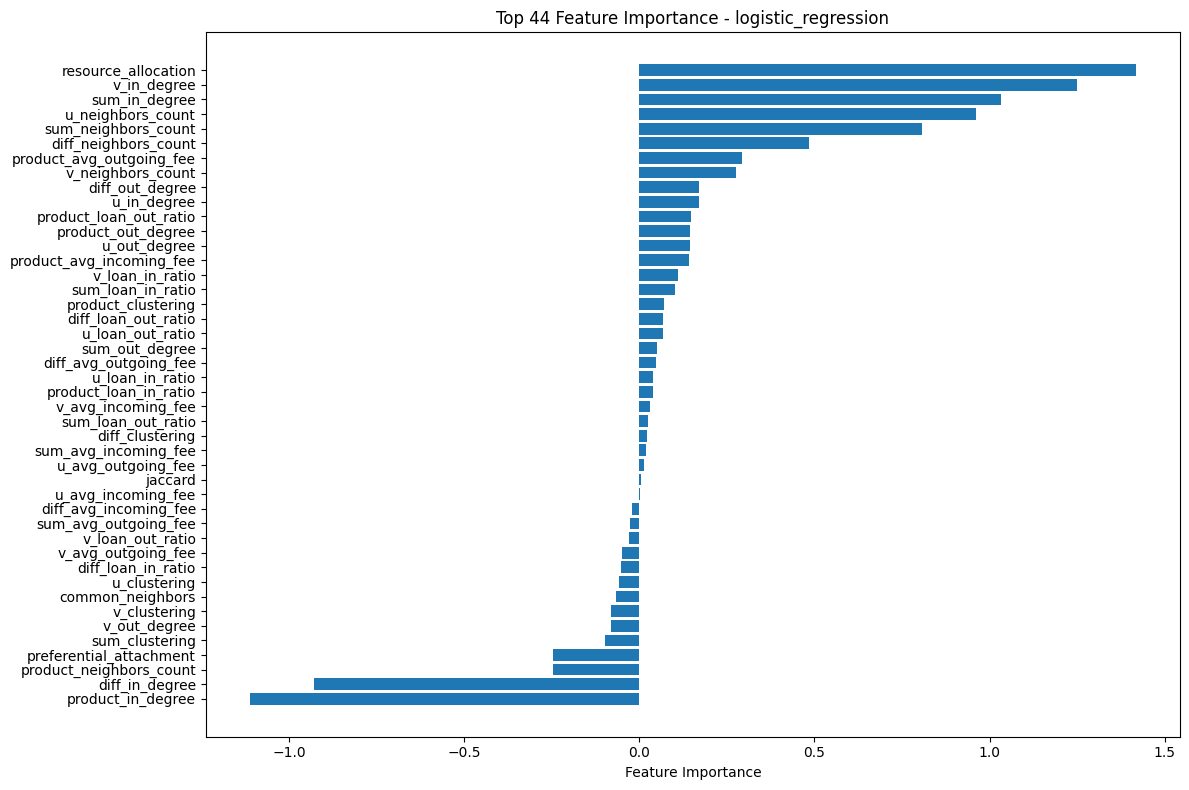

In [77]:
predictor.plot_feature_importance("logistic_regression")